In [4]:
!pip install tensorflow-addons

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, GRU, Dropout, Bidirectional, LayerNormalization, Input, Add, Conv1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf

# set memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print(e)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

combined_features_path = '/content/drive/My Drive/Data/c_features.pkl'
y_df_path = '/content/drive/My Drive/Data/c_target.pkl'

Mounted at /content/drive
Num GPUs Available:  1


In [7]:
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

def calculate_log_loss(actual, forecast):
    return np.mean((np.log(actual / forecast))**2)

In [8]:
combined_features = pd.read_pickle(combined_features_path)
y_df = pd.read_pickle(y_df_path)

y = y_df.values.flatten()

combined_features = combined_features.loc[y_df.index]

splits = TimeSeriesSplit(n_splits=5)

3/3 [==============================] - 1s 6ms/step
y_test_seq.shape: (96,), forecast.shape: (96,)
3/3 [==============================] - 0s 6ms/step
y_test_seq.shape: (96,), forecast.shape: (96,)
3/3 [==============================] - 0s 6ms/step
y_test_seq.shape: (96,), forecast.shape: (96,)
3/3 [==============================] - 0s 6ms/step
y_test_seq.shape: (96,), forecast.shape: (96,)
3/3 [==============================] - 0s 6ms/step
y_test_seq.shape: (96,), forecast.shape: (96,)
Average MAE: 17.96382789580027
Average MAPE: 32.16213009044672
Average Log Loss: 0.2539801344063972



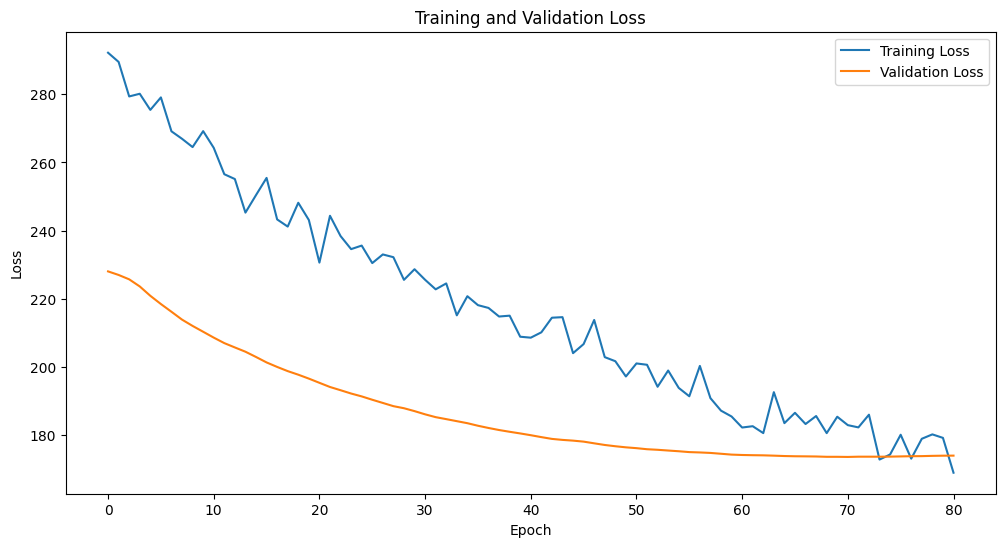

In [9]:
class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.history = {'loss': [], 'val_loss': []}

    def on_epoch_end(self, epoch, logs=None):
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))

def multi_head_attention_layer(inputs, head_size, num_heads):
    query = Dense(head_size * num_heads)(inputs)
    key = Dense(head_size * num_heads)(inputs)
    value = Dense(head_size * num_heads)(inputs)

    query = tf.split(query, num_heads, axis=-1)
    key = tf.split(key, num_heads, axis=-1)
    value = tf.split(value, num_heads, axis=-1)

    attention_outputs = []
    for q, k, v in zip(query, key, value):
        attention_score = tf.matmul(q, k, transpose_b=True) / tf.sqrt(tf.cast(head_size, tf.float32))
        attention_weights = tf.nn.softmax(attention_score, axis=-1)
        attention_output = tf.matmul(attention_weights, v)
        attention_outputs.append(attention_output)

    concat_attention = tf.concat(attention_outputs, axis=-1)
    output = Dense(inputs.shape[-1])(concat_attention)

    return output

def temporal_fusion_transformer(input_shape):
    inputs = Input(shape=input_shape)

    # CNN filter for local feature extraction
    adjusted_inputs = Conv1D(filters=64, kernel_size=2, padding='same')(inputs)

    # multi-headed attention
    attention = multi_head_attention_layer(adjusted_inputs, head_size=16, num_heads=4)

    attention = Conv1D(filters=64, kernel_size=2, padding='same')(attention)
    x = Add()([adjusted_inputs, attention])
    x = LayerNormalization()(x)

    # position-wise feed-forward layer
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Add()([adjusted_inputs, x])
    x = LayerNormalization()(x)

    # GRU layers
    x = Bidirectional(GRU(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(GRU(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation='selu')(x)
    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def create_sequences(X, y, time_steps=15):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

def preprocess_features(X):
    scaler = StandardScaler()
    minmax_scaler = MinMaxScaler()

    X_scaled = scaler.fit_transform(X)
    X_scaled = minmax_scaler.fit_transform(X_scaled)

    X_scaled[np.isnan(X_scaled)] = 0
    X_scaled[np.isinf(X_scaled)] = 0

    return X_scaled

forecasts = []
forecast_indices = []
mae_scores = []
mape_scores = []
log_loss_scores = []
history = LossHistory()

splits = TimeSeriesSplit(n_splits=5)

time_steps = 15
input_shape = (time_steps, combined_features.shape[1])
model = temporal_fusion_transformer(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

for train_idx, test_idx in splits.split(combined_features):
    X_train, X_test = combined_features.iloc[train_idx], combined_features.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train_scaled = preprocess_features(X_train)
    X_test_scaled = preprocess_features(X_test)

    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

    model.fit(X_train_seq, y_train_seq, epochs=300, batch_size=64, validation_split=0.2, verbose=0,
              callbacks=[early_stopping, reduce_lr, history])

    forecast = model.predict(X_test_seq).flatten()

    print(f"y_test_seq.shape: {y_test_seq.shape}, forecast.shape: {forecast.shape}")

    if len(y_test_seq) == len(forecast):
        forecasts.extend(forecast)
        forecast_indices.extend(test_idx[time_steps:])  # Adjust indices due to sequence creation

        mae = mean_absolute_error(y_test_seq, forecast)
        mae_scores.append(mae)
        mape_scores.append(calculate_mape(y_test_seq, forecast))
        log_loss_scores.append(calculate_log_loss(y_test_seq, forecast))
    else:
        print("Warning: Length mismatch between y_test_seq and forecast")

average_mae = np.mean(mae_scores)
average_mape = np.mean(mape_scores)
average_log_loss = np.mean(log_loss_scores)

print(f"Average MAE: {average_mae}")
print(f"Average MAPE: {average_mape}")
print(f"Average Log Loss: {average_log_loss}\n")

naive_mae_scores = []
naive_mape_scores = []
naive_log_loss_scores = []

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
for train_idx, test_idx in splits.split(combined_features):
    naive_forecast = y_train[-1]
    actual_test = y[test_idx[0]]

    # Ensure no overlap
    assert max(train_idx) < min(test_idx), "Train/test split overlap detected."

    # naive forecast losses
    naive_mae = mean_absolute_error([actual_test], [naive_forecast])
    naive_mape = calculate_mape(np.array([actual_test]), np.array([naive_forecast]))
    naive_log_loss = calculate_log_loss(np.array([actual_test]), np.array([naive_forecast]))

    naive_mae_scores.append(naive_mae)
    naive_mape_scores.append(naive_mape)
    naive_log_loss_scores.append(naive_log_loss)

# avg losses for naive forecasts
average_naive_mae = np.mean(naive_mae_scores)
average_naive_mape = np.mean(naive_mape_scores)
average_naive_log_loss = np.mean(naive_log_loss_scores)

print(f"\nGRU Est:    Avg MAE: . . . . . {average_mae:.3f}")
print(f"             Avg MAPE:. . . . . {average_mape:.3f}")
print(f"             Avg Log Loss:. . . {average_log_loss:.5f}\n")

print(f"Naive Est:   Avg MAE: . . . . . {average_naive_mae:.3f}")
print(f"             Avg MAPE:. . . . . {average_naive_mape:.3f}")
print(f"             Avg Log Loss:. . . {average_naive_log_loss:.5f}")


GRU Est:    Avg MAE: . . . . . 17.964
             Avg MAPE:. . . . . 32.162
             Avg Log Loss:. . . 0.25398

Naive Est:   Avg MAE: . . . . . 21.396
             Avg MAPE:. . . . . 58.669
             Avg Log Loss:. . . 0.28992
